# Comparing Classifiers - `ImageNet-ReaL`

In [1]:
import json
import os
import pickle
import random
from collections import Counter, defaultdict
from functools import partial
from glob import glob

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as fv
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

sns.set()

In [2]:
# Set environment variables
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Load ImageNet labels
with open("imagenet-labels.json", "r") as f:
    wnid_to_label = json.load(f)

# Load dataset folder
dataset_folder = ImageFolder("/home/mohammad/dataset/ILSVRC2012_img_val/")
gt_labels = [x[1] for x in dataset_folder.imgs]
id_to_label = {x[1]: wnid_to_label[x[0].split("/")[-2]] for x in dataset_folder.imgs}

# Extract classifier names from filenames
saved_files = list(sorted(glob("./ILSVRC2012_img_val/predictions*/*.pickle")))
classifier_names = set(
    fname.split("/")[-1].replace("ILSVRC2012_img_val-", "").split("-")[0]
    for fname in saved_files
)

In [3]:
# ImageNet Labels
gt_labels = np.asarray([x[1] for x in dataset_folder.imgs])
id_to_label = {x[1]: wnid_to_label[x[0].split("/")[-2]] for x in dataset_folder.imgs}

# ReaL Labels
with open("real.json", "r") as f:
    ReaL_labels = json.load(f)


def get_real_labels(img_path):
    return ReaL_labels[int(img_path.split("/")[-1].split(".")[0].split("_")[-1]) - 1]


gt_real_map = {i: get_real_labels(x[0]) for i, x in enumerate(dataset_folder.imgs)}

bad_ids = [x for x in gt_real_map.keys() if len(gt_real_map[x]) == 0]
good_ids = [x for x in gt_real_map.keys() if len(gt_real_map[x]) != 0]

In [4]:
# Load results for each classifier
all_results = defaultdict(dict)
for fname in saved_files:
    with open(fname, "rb") as f:
        content = pickle.load(f)

        classifier_name = (
            fname.split("/")[-1].replace("ILSVRC2012_img_val-", "").split("-")[0]
        )
        model_name = os.path.basename(fname).split(".")[0]
        all_results[classifier_name][model_name] = content

In [5]:
# Define helper functions
def member_check(name, col):
    return [x in gt_real_map[name] for x in col]


def multi_func(member_check):
    def f(col):
        return member_check(col.name, col)

    return f


def get_one_df_correctness(classifier_name, list_of_models):
    correctness = {}
    for model_name in list_of_models:
        predictions = all_results[classifier_name][model_name]
        correctness[model_name] = {}
        for tsize in predictions.keys():
            correctness[model_name][
                f"LOC:{'_'.join(model_name.split('_')[-2:])}_Size:{tsize}"
            ] = predictions[tsize]
    list_of_dfs = []
    for model_name in correctness.keys():
        df_a = pd.DataFrame(correctness[model_name]).T
        df_a = df_a[df_a.columns.intersection(good_ids)]
        df_a = df_a.apply(multi_func(member_check))
        list_of_dfs.append(df_a)
    df = pd.concat(list_of_dfs)
    return df

In [6]:
# Get results for each classifier
model_correctness_pair = {}
for classifier in classifier_names:
    models_of_classifier = list(all_results[classifier].keys())
    correctness_df = get_one_df_correctness(classifier, models_of_classifier)
    model_correctness_pair[classifier] = {
        "correctness_df": correctness_df,
        "max_possible_accuracy": correctness_df.max(0).mean(),
        "standard_1-crop_accuracy": np.mean(correctness_df.loc["LOC:1_1_Size:256"]),
    }

print(model_correctness_pair.keys())

dict_keys(['vit_b_32', 'convnext_base', 'maxvit_t', 'swin_b', 'resnet50', 'efficientnet_b0', 'mobilenet_v3_small'])


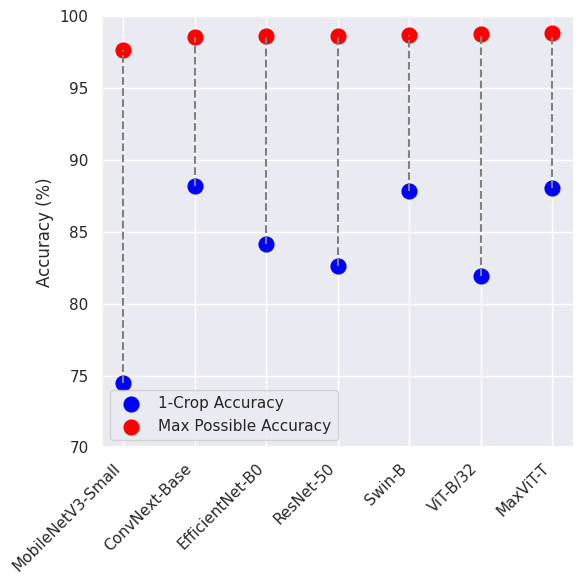

In [7]:
# Mapping of classifier names to pretty formats
name_mapping = {
    "resnet50": "ResNet-50",
    "vit_b_32": "ViT-B/32",
    "mobilenet_v3_small": "MobileNetV3-Small",
    "maxvit_t": "MaxViT-T",
    "efficientnet_b0": "EfficientNet-B0",
    "swin_b": "Swin-B",
    "convnext_base": "ConvNext-Base",
}

# Your data, multiplied by 100
max_possible_accuracy = {
    k: 100 * float(v["max_possible_accuracy"])
    for k, v in model_correctness_pair.items()
}

standard_1_crop_accuracy = {
    k: 100 * float(v["standard_1-crop_accuracy"])
    for k, v in model_correctness_pair.items()
}

# Sort classifiers by max possible accuracy
sorted_classifiers = sorted(max_possible_accuracy, key=max_possible_accuracy.get)

# Classifier names (pretty format) and corresponding accuracy values
classifiers = [name_mapping[classifier] for classifier in sorted_classifiers]
max_accuracies = [
    max_possible_accuracy[classifier] for classifier in sorted_classifiers
]
standard_accuracies = [
    standard_1_crop_accuracy[classifier] for classifier in sorted_classifiers
]

# X-axis positions
x = np.arange(len(classifiers))

# Create scatter plot with square size and larger markers
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(
    x, standard_accuracies, label="1-Crop Accuracy", color="blue", marker=".", s=450
)
ax.scatter(
    x, max_accuracies, label="Max Possible Accuracy", color="red", marker=".", s=450
)

# Draw lines between 1-crop and max for each classifier
for i in range(len(classifiers)):
    ax.plot(
        [x[i], x[i]],
        [standard_accuracies[i], max_accuracies[i]],
        color="grey",
        linestyle="--",
    )

# Add labels, title, and legend
ax.set_ylabel("Accuracy (%)")
ax.set_xticks(x)
ax.set_xticklabels(
    classifiers, rotation=45, ha="right"
)  # Align xtick labels to the right
ax.legend()
# set y-axis range 0 to 100
ax.set_ylim([70, 100])

# Show plot
plt.tight_layout()
plt.show()

## Min Cover

In [8]:
from collections import defaultdict
from tqdm import tqdm


def set_cover(subsets):
    elements = set(e for s in subsets.values() for e in s)
    covered = set()
    cover = []
    while covered != elements:
        key_, value_ = max(subsets.items(), key=lambda x: len(set(x[1]) - covered))
        cover.append(key_)
        covered |= set(value_)

    return cover


def get_min_cover(correctness_dfs):
    graph = {}
    min_cover = {}

    backup_graph = defaultdict(list)
    nodes_a = list(correctness_dfs.index)

    for n1 in tqdm(nodes_a, total=len(nodes_a)):
        backup_graph[n1].extend(
            list(correctness_dfs.loc[n1][correctness_dfs.loc[n1]].index)
        )

    graph["model"] = backup_graph

    for k, correctness_dfs in tqdm(graph.items(), total=len(graph)):
        S = [set(x) for x in list(correctness_dfs.values())]
        min_cover[k] = set_cover(correctness_dfs)

    return list(min_cover.values())


min_covers = {}

for classifier in classifier_names:
    correctness_df = model_correctness_pair[classifier]["correctness_df"]
    min_covers[classifier] = get_min_cover(correctness_df)
    print(f"{classifier} min-cover: {len(min_covers[classifier][0])}")

# Now, min_covers contains the min-cover for each classifier

100%|██████████| 1/1 [01:05<00:00, 65.28s/it]


vit_b_32 min-cover: 172


100%|██████████| 1/1 [01:01<00:00, 61.36s/it]


convnext_base min-cover: 157


100%|██████████| 1/1 [01:05<00:00, 65.96s/it]


maxvit_t min-cover: 155


100%|██████████| 1/1 [01:10<00:00, 70.86s/it]


swin_b min-cover: 167


100%|██████████| 1/1 [01:03<00:00, 63.35s/it]


resnet50 min-cover: 175


100%|██████████| 1/1 [01:04<00:00, 64.88s/it]


efficientnet_b0 min-cover: 171


100%|██████████| 1/1 [01:01<00:00, 61.76s/it]

mobilenet_v3_small min-cover: 209


In [9]:
top_36_accuracy = {}
for classifier in classifier_names:
    correctness_df = model_correctness_pair[classifier]["correctness_df"]
    top_36_transforms = min_covers[classifier][0][:36]

    # Calculate accuracy for top-36 transformations
    accuracies_for_top_36 = correctness_df.loc[top_36_transforms].max(0).mean()
    top_36_accuracy[classifier] = 100 * accuracies_for_top_36

# Now, sort the top-36 accuracies according to the sorted classifiers
top_36_accuracies = [top_36_accuracy[classifier] for classifier in sorted_classifiers]

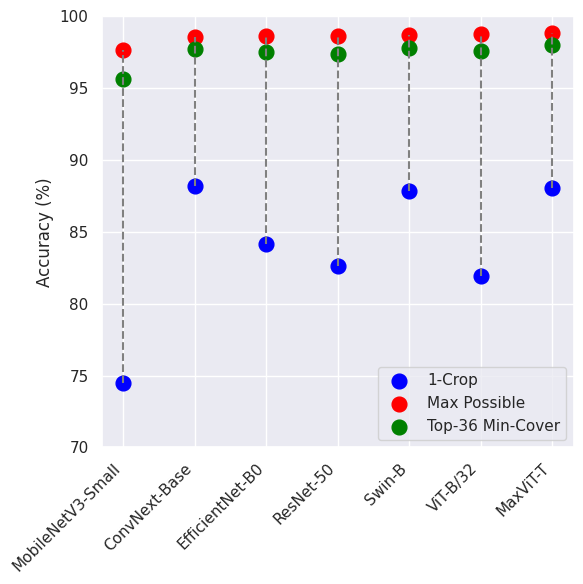

In [10]:
# Mapping of classifier names to pretty formats
name_mapping = {
    "resnet50": "ResNet-50",
    "vit_b_32": "ViT-B/32",
    "mobilenet_v3_small": "MobileNetV3-Small",
    "maxvit_t": "MaxViT-T",
    "efficientnet_b0": "EfficientNet-B0",
    "swin_b": "Swin-B",
    "convnext_base": "ConvNext-Base",
}

# Your data, multiplied by 100
max_possible_accuracy = {
    k: 100 * float(v["max_possible_accuracy"])
    for k, v in model_correctness_pair.items()
}

standard_1_crop_accuracy = {
    k: 100 * float(v["standard_1-crop_accuracy"])
    for k, v in model_correctness_pair.items()
}

# Sort classifiers by max possible accuracy
sorted_classifiers = sorted(max_possible_accuracy, key=max_possible_accuracy.get)

# Classifier names (pretty format) and corresponding accuracy values
classifiers = [name_mapping[classifier] for classifier in sorted_classifiers]
max_accuracies = [
    max_possible_accuracy[classifier] for classifier in sorted_classifiers
]
standard_accuracies = [
    standard_1_crop_accuracy[classifier] for classifier in sorted_classifiers
]

# X-axis positions
x = np.arange(len(classifiers))

# Create scatter plot with square size and larger markers
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x, standard_accuracies, label="1-Crop", color="blue", marker=".", s=450)
ax.scatter(x, max_accuracies, label="Max Possible", color="red", marker=".", s=450)

ax.scatter(
    x,
    top_36_accuracies,
    label="Top-36 Min-Cover",
    color="green",
    marker=".",
    s=450,
)


# Draw lines between 1-crop and max for each classifier
for i in range(len(classifiers)):
    ax.plot(
        [x[i], x[i]],
        [standard_accuracies[i], max_accuracies[i]],
        color="grey",
        linestyle="--",
    )

# Add labels, title, and legend
ax.set_ylabel("Accuracy (%)")
ax.set_xticks(x)
ax.set_xticklabels(
    classifiers, rotation=45, ha="right"
)  # Align xtick labels to the right
ax.legend()
# set y-axis range 0 to 100
ax.set_ylim([70, 100])

# Show plot
plt.tight_layout()
fig.savefig(
    "imagenet-ReaL-1crop-vs-36crop-vs-max-possible-accuracy.pdf",
    bbox_inches="tight",
    pad_inches=0.05,
)
plt.show()

In [12]:
# Import pandas
import pandas as pd

# Create a DataFrame
accuracy_df = pd.DataFrame(
    {
        "Classifier": classifiers,
        "Max Possible Accuracy": max_accuracies,
        "Standard 1-Crop Accuracy": standard_accuracies,
        "Top 36 Accuracies": top_36_accuracies,
    }
)

# Display the DataFrame
accuracy_df

,Classifier,Max Possible Accuracy,Standard 1-Crop Accuracy,Top 36 Accuracies
0,MobileNetV3-Small,97.657835,74.471038,95.627389
1,ConvNext-Base,98.526806,88.193095,97.679185
2,EfficientNet-B0,98.603668,84.125798,97.491300
3,ResNet-50,98.625019,82.626983,97.352520
4,Swin-B,98.693341,87.804514,97.745372
5,ViT-B/32,98.753123,81.892521,97.600188
6,MaxViT-T,98.832120,88.052181,97.988770
